In [1]:
#Imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
#Load Data
data = pd.read_csv('data/AEP_hourly.csv', index_col=0, parse_dates=True)

#Sort the dataframe
data.sort_values('Datetime', inplace=True)

In [3]:
#Methods
def make_X_Y(ts:list, lag:int, n_ahead:int):
    """
    Create X and Y matrices needed for NN training
    """
    X,Y = [], []

    if len(ts) - lag <=0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[i + lag : i + lag + n_ahead])
            X.append(ts[i:i+lag])

    X,Y = np.array(X), np.array(Y)

    #reshape array into standard form for timeseries
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X,Y

def make_train_test_data(ts:list, lag:int, train_test_split:float, n_ahead:int):
    """
    Create training and testing data for NN
    """
    #create X and Y matrices
    X,Y = make_X_Y(ts, lag, n_ahead)

    #split into test and train
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []

    if train_test_split > 0:
        idx = round(len(X) * train_test_split)
        X_train = X[:(len(X) - idx)]
        X_test = X[-idx:]

        Y_train = Y[:(len(Y) - idx)]
        Y_test = Y[-idx:]

    return X_train, X_test, Y_train, Y_test

1-Step Ahead Prediction

In [4]:
#Deep Learning

#number of neurons in LSTM layer
n_layer = 50

#number of lags
n_lag = 3

# number of steps ahead to predict
n_ahead = 1

#Model
model = keras.Sequential(
    [
    layers.LSTM(n_layer, activation='relu', input_shape=(n_lag,1)),
    layers.Dense(1)
    ]
)
#compile model
model.compile(optimizer='adam', loss='mse')

epochs = 10
batch_size = 256
train_test_split = 0.15

#create train and testing data
X_train, X_test, Y_train, Y_test = make_train_test_data(list(data['AEP_MW']), n_lag, train_test_split, n_ahead)

#create a dict for keras training args
keras_dict = {
    'x':X_train,
    'y':Y_train,
    'batch_size':batch_size,
    'epochs':epochs,
    'shuffle':False,
    'validation_data':(X_test,Y_test)
}

In [5]:
#fit the model
model.fit(**keras_dict)

Epoch 1/10
403/403 [==============================] - 1s 3ms/step - loss: 41608688.0000 - val_loss: 1129835.7500
Epoch 2/10
403/403 [==============================] - 1s 3ms/step - loss: 929451.0000 - val_loss: 574304.1250
Epoch 3/10
403/403 [==============================] - 1s 3ms/step - loss: 415075.2188 - val_loss: 210083.5312
Epoch 4/10
403/403 [==============================] - 1s 3ms/step - loss: 190028.6875 - val_loss: 125555.4453
Epoch 5/10
403/403 [==============================] - 1s 3ms/step - loss: 160119.5000 - val_loss: 119619.3984
Epoch 6/10
403/403 [==============================] - 1s 3ms/step - loss: 158147.8750 - val_loss: 118461.4453
Epoch 7/10
403/403 [==============================] - 1s 3ms/step - loss: 157201.7188 - val_loss: 117702.6094
Epoch 8/10
403/403 [==============================] - 1s 3ms/step - loss: 156456.7031 - val_loss: 117101.3750
Epoch 9/10
403/403 [==============================] - 1s 3ms/step - loss: 155827.2188 - val_loss: 116612.8125
Epoch 1

In [6]:
#predict
yhat = []
yhat = [y[0] for y in model.predict(X_test)]

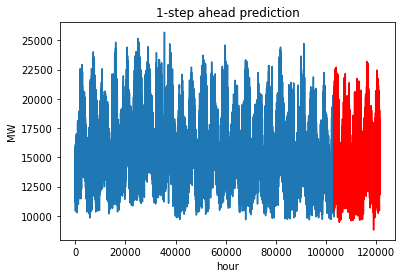

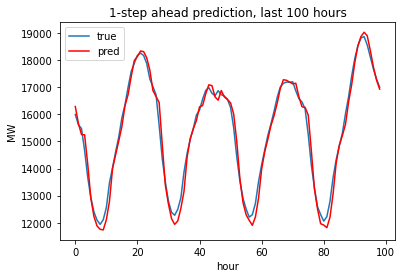

In [7]:
#Compare training data and 1 step ahead prediction
idx_train = len(Y_train)
idx_test = len(Y_test)
train_range = range(0, idx_train)
test_range = range(idx_train, idx_train + idx_test)
plt.plot(range(0,len(Y_train)),Y_train)
plt.plot(test_range,yhat,'r')
plt.title('1-step ahead prediction')
plt.xlabel('hour')
plt.ylabel('MW')
plt.show()

n_last = 100
plt.plot(Y_test[-n_last:-1],label='true')
plt.plot(yhat[-n_last:-1],'r',label='pred')
plt.title('1-step ahead prediction, last ' + str(n_last) + ' hours')
plt.xlabel('hour')
plt.ylabel('MW')
plt.legend()
plt.show()
